<a href="https://colab.research.google.com/github/andresenrique08/ML_2020/blob/master/Reto%203/Reto3_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reto 3.0

### Curso de Machine Learning 2020-20
Autores:
*    Andrés Enrique Ávila Rojas (201319127)
*   Jeison Alexander Timana Rangel (201617870)

In [36]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modulos para contingencias
from scipy.stats import chi2
from scipy.stats import chi2_contingency

Se toman los datos del repositorio de github con el siguiente link https://raw.githubusercontent.com/andresenrique08/ML_2020/master/Reto%203/msd_genre_dataset.txt

In [2]:
# Reading file from github
url = "https://raw.githubusercontent.com/andresenrique08/ML_2020/master/Reto%203/msd_genre_dataset.txt"
data  = pd.read_csv(url,skiprows=9, sep=",") 
data.head()

,%genre,track_id,artist_name,title,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,avg_timbre2,avg_timbre3,avg_timbre4,avg_timbre5,avg_timbre6,avg_timbre7,avg_timbre8,avg_timbre9,avg_timbre10,avg_timbre11,avg_timbre12,var_timbre1,var_timbre2,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
0,classic pop and rock,TRFCOOU128F427AEC0,Blue Oyster Cult,Mes Dames Sarat,-8.697,155.007,1,9,1,246.33424,46.673067,14.613684,14.664215,0.176561,-9.346377,-12.341699,11.183382,7.405288,9.313765,3.201169,-0.152734,5.809709,14.930820,802.205948,1255.514569,580.030472,598.485223,575.337671,322.068603,321.726029,232.700609,186.805303,181.938688,151.508011
1,classic pop and rock,TRNJTPB128F427AE9F,Blue Oyster Cult,Screams,-10.659,148.462,1,4,0,189.80526,43.645377,-87.337150,41.051582,7.814770,-12.989848,-14.253599,6.126045,-2.448662,22.691713,-2.872706,1.427725,-6.710730,22.704843,1561.307072,2007.653070,1043.474073,585.694981,564.013736,510.177022,400.200186,365.119588,238.099708,197.933757,251.577525
2,classic pop and rock,TRLFJHA128F427AEEA,Blue Oyster Cult,Dance The Night Away,-13.494,112.909,1,10,0,158.19710,37.573538,-61.202030,28.760533,-13.788123,10.062347,-4.872030,-14.090243,5.580175,15.414011,4.556137,-1.877363,20.879475,58.459621,4644.001846,1204.856777,2736.520024,730.233239,665.203452,535.775111,439.335059,486.822970,265.333860,447.097987,251.880724
3,classic pop and rock,TRCQZAG128F427DB97,Blue Oyster Cult,Debbie Denise,-12.786,117.429,4,7,1,250.22649,42.566615,17.217897,53.484213,1.564362,-8.884632,-13.088890,-9.762620,1.373769,1.092876,1.479490,1.517015,8.562618,22.575460,691.140671,809.755802,563.908070,492.803819,378.382799,372.875044,231.941957,246.313305,168.400152,85.282462,339.897173
4,classic pop and rock,TRNXMNM128F427DB8C,Blue Oyster Cult,(Don't Fear) The Reaper,-14.093,141.536,4,9,0,307.06893,40.976507,-13.609779,39.566169,-5.602033,-17.754819,-21.833261,-5.600732,2.291770,3.526177,1.535449,2.763958,3.388757,34.294994,1062.180815,1093.684935,343.556047,889.163314,218.111796,304.862864,178.352161,440.478867,142.669283,81.061326,208.355152


Los géneros presentes en la base de datos son los siguientes:

In [6]:
generos = data['%genre'].unique()
generos = pd.DataFrame(data=generos, columns=['Generos'])
generos

,Generos
0,classic pop and rock
1,punk
2,folk
3,pop
4,dance and electronica
5,metal
6,jazz and blues
7,classical
8,hip-hop
9,soul and reggae


## Preparación de los datos

Teniendo en cuenta que se espera resolver el problema de clasificación binaria (usando ```scikit-learn```) entre los géneros jazz and blues y soul and reggae, se procede a crear un dataframe con solo la información correspondiente a estos dos géneros.



In [19]:
data_bin = data.loc[(data['%genre']=='jazz and blues') | (data['%genre']=='soul and reggae')]
data_bin.head()

,%genre,track_id,artist_name,title,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,avg_timbre2,avg_timbre3,avg_timbre4,avg_timbre5,avg_timbre6,avg_timbre7,avg_timbre8,avg_timbre9,avg_timbre10,avg_timbre11,avg_timbre12,var_timbre1,var_timbre2,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
48942,jazz and blues,TRJBLUX12903CE16EC,John Stevens,Mango,-18.996,89.147,1,0,1,256.86159,34.738162,-50.948828,20.177101,15.139567,-25.836751,7.729854,-23.534951,-7.002408,9.661461,-0.752980,6.760097,17.112598,12.473302,1530.622764,1649.321047,1221.638146,501.717892,1091.743641,618.560018,402.236969,309.392602,233.206167,261.850703,240.834177
48943,jazz and blues,TRDPDLX12903CE16F2,John Stevens,Carnaval,-19.347,125.825,4,2,1,301.87057,34.033346,-39.733083,30.640298,19.646264,-45.231415,9.103613,-19.019581,1.119047,9.169450,3.999394,5.481075,10.958845,11.150600,1385.186042,1670.689893,1339.193474,889.918742,1148.824912,428.976969,306.187624,368.973940,227.275123,261.643570,332.356536
48944,jazz and blues,TRMWVBM128F42374DA,John Stevens,My Blue Heaven (Album Version),-9.472,121.707,4,2,1,158.85016,41.794197,-22.133118,3.518487,1.868059,13.542078,6.944006,15.406498,5.469637,4.822017,1.792601,-10.094489,-2.143374,41.497045,4513.995103,2640.398239,3070.791615,1347.758671,1499.491510,1015.076345,897.411739,608.034880,549.493210,481.149049,442.663136
48945,jazz and blues,TRMLIWL128F42374DE,John Stevens,Here_ There And Everywhere (Album Version),-14.406,83.012,5,0,1,181.26322,38.637530,-64.807191,-21.920418,-25.058971,-2.520459,-11.979187,-4.021518,-4.502840,1.350948,-6.206154,-2.557249,1.841054,26.279428,2304.536939,1187.644248,1311.170435,809.621938,612.699944,492.734025,525.801667,585.984445,278.578591,250.545027,348.842236
48946,jazz and blues,TRGFUVB128F42374E1,John Stevens,This Love (Album Version),-9.289,76.013,4,7,0,248.89424,43.089845,-27.351674,14.205832,-6.941388,21.278516,-9.627968,-6.894824,-2.730303,2.003291,-2.030266,-0.764775,1.769443,37.786419,3726.684916,1164.272074,1536.674490,1167.316436,580.604008,498.168561,607.747214,367.191519,403.532772,262.670577,272.634634


Para asegurarnos que solo estén los generos que se usarán para el análisis, se verifica que solo estos géneros esten en nuestro nuevo dataframe



In [7]:
generos = data_bin['%genre'].unique()
generos = pd.DataFrame(data=generos, columns=['Generos'])
generos

,Generos
0,jazz and blues
1,soul and reggae


Ahora comparamos cuantos datos de cada género hay en nuestro dataframe, obteniendo el siguiente histograma

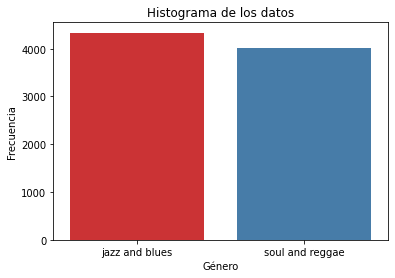

jazz and blues     0.519042
soul and reggae    0.480958
Name: %genre, dtype: float64

In [16]:
f, ax = plt.subplots()
ax = sns.countplot(x="%genre", data=data_bin, palette="Set1")
plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.title('Histograma de los datos')
plt.show()
data_bin['%genre'].value_counts()/len(data_bin)

En esta oportunidad no se tendrá en cuenta la columna correspondiente a ```artist_name``` debido a que este dato puede generar un error en el modelamiento del clasificador afectando los resultados de predicción, considerando que esta variable provee información adicional que facilita su clasificación. Con esto en mente, se obtiene la siguiente información.


In [20]:
data_bin = data_bin.drop(['artist_name'],axis=1)
data_bin.head()

,%genre,track_id,title,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,avg_timbre2,avg_timbre3,avg_timbre4,avg_timbre5,avg_timbre6,avg_timbre7,avg_timbre8,avg_timbre9,avg_timbre10,avg_timbre11,avg_timbre12,var_timbre1,var_timbre2,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
48942,jazz and blues,TRJBLUX12903CE16EC,Mango,-18.996,89.147,1,0,1,256.86159,34.738162,-50.948828,20.177101,15.139567,-25.836751,7.729854,-23.534951,-7.002408,9.661461,-0.752980,6.760097,17.112598,12.473302,1530.622764,1649.321047,1221.638146,501.717892,1091.743641,618.560018,402.236969,309.392602,233.206167,261.850703,240.834177
48943,jazz and blues,TRDPDLX12903CE16F2,Carnaval,-19.347,125.825,4,2,1,301.87057,34.033346,-39.733083,30.640298,19.646264,-45.231415,9.103613,-19.019581,1.119047,9.169450,3.999394,5.481075,10.958845,11.150600,1385.186042,1670.689893,1339.193474,889.918742,1148.824912,428.976969,306.187624,368.973940,227.275123,261.643570,332.356536
48944,jazz and blues,TRMWVBM128F42374DA,My Blue Heaven (Album Version),-9.472,121.707,4,2,1,158.85016,41.794197,-22.133118,3.518487,1.868059,13.542078,6.944006,15.406498,5.469637,4.822017,1.792601,-10.094489,-2.143374,41.497045,4513.995103,2640.398239,3070.791615,1347.758671,1499.491510,1015.076345,897.411739,608.034880,549.493210,481.149049,442.663136
48945,jazz and blues,TRMLIWL128F42374DE,Here_ There And Everywhere (Album Version),-14.406,83.012,5,0,1,181.26322,38.637530,-64.807191,-21.920418,-25.058971,-2.520459,-11.979187,-4.021518,-4.502840,1.350948,-6.206154,-2.557249,1.841054,26.279428,2304.536939,1187.644248,1311.170435,809.621938,612.699944,492.734025,525.801667,585.984445,278.578591,250.545027,348.842236
48946,jazz and blues,TRGFUVB128F42374E1,This Love (Album Version),-9.289,76.013,4,7,0,248.89424,43.089845,-27.351674,14.205832,-6.941388,21.278516,-9.627968,-6.894824,-2.730303,2.003291,-2.030266,-0.764775,1.769443,37.786419,3726.684916,1164.272074,1536.674490,1167.316436,580.604008,498.168561,607.747214,367.191519,403.532772,262.670577,272.634634


Continuando con el pre procesamiento de los datos, pasaremos a verificar los datos nulos dentro del dataframe

In [24]:
missing_values_count = data_bin.isnull().sum()
total_missing = missing_values_count.sum()
print('Hay {} datos perdidos en el dataframe'.format(total_missing))

Hay 0 datos perdidos en el dataframe


Se observa que no hay datos perdidos. Ahora, se procede a verificar si hay filas duplicadas.


In [27]:
print('Hay {} filas duplicadas en el dataframe'.format(data_bin.duplicated().sum()))

Hay 0 filas duplicadas en el dataframe


Una vez observado que no hay filas duplicadas ni datos perdidos, se procede a verificar el tipo de las variables del dataframe.

In [28]:
data_bin.dtypes

%genre             object
track_id           object
title              object
loudness          float64
tempo             float64
time_signature      int64
key                 int64
mode                int64
duration          float64
avg_timbre1       float64
avg_timbre2       float64
avg_timbre3       float64
avg_timbre4       float64
avg_timbre5       float64
avg_timbre6       float64
avg_timbre7       float64
avg_timbre8       float64
avg_timbre9       float64
avg_timbre10      float64
avg_timbre11      float64
avg_timbre12      float64
var_timbre1       float64
var_timbre2       float64
var_timbre3       float64
var_timbre4       float64
var_timbre5       float64
var_timbre6       float64
var_timbre7       float64
var_timbre8       float64
var_timbre9       float64
var_timbre10      float64
var_timbre11      float64
var_timbre12      float64
dtype: object

Se puede observar que hay 3 variables categoricas y todas las demás son númericas. Una de las variables categoricas corresponde a la variable ```%genre```, la cual es nuestra variable objetivo por lo tanto es necesario ver el comportamiento de las otras variables para conocer si pueden o no influir el modelo de clasificación. Para ello procederemos a verficar el total de valores únicos y compararlos con la longitud total de los datos del dataframe, de la siguiente forma.

In [33]:
total_data = len(data_bin)
tot_track_id = len(data_bin.track_id.unique())
tot_title= len(data_bin.title.unique())

if total_data == tot_track_id:
  print('Los valores únicos de la variable track_id son iguales al total de datos, por lo que no aportan información relevante. \n')
else:
  print('La variable track_id puede aportar información útil para el análisis y se debe revisar en detalle. \n')

if total_data == tot_title:
  print('Los valores únicos de la variable title son iguales al total de datos, por lo que no aportan información relevante.')
else:
  print('La variable title puede aportar información útil para el análisis y se debe revisar en detalle.')


Los valores únicos de la variable track_id son iguales al total de datos, por lo que no aportan información relevante. 

La variable title puede aportar información útil para el análisis y se debe revisar en detalle.


Se observa que la variable ```track_id``` puede ser eliminada del modelo, puesto que no aporta información relavante para la clasificación y hay un track_id diferente para cada fila. Por su parte la variable ```title``` no contiene un valor diferente por cada fila, lo que muestra que algunos de los títulos de las canciones se repiten, esto puede deberse a que diferentes autores nombraron de igual forma algunas canciones o debido a otros factores. Para comprobar que la variable objetivo ```%genre``` no tenga dependencia de esta variable, se realiza un análisis de contingencia con chi-cuadrado como se muestra a continuación.

In [42]:
Tabla_c = pd.crosstab(index=data_bin['%genre'],columns=data_bin["title"],margins=True)
chi2_contingency(Tabla_c)

(8183.224779508331,
 1.0,
 14690,
 array([[5.19041916e-01, 5.19041916e-01, 5.19041916e-01, ...,
         5.19041916e-01, 5.19041916e-01, 4.33400000e+03],
        [4.80958084e-01, 4.80958084e-01, 4.80958084e-01, ...,
         4.80958084e-01, 4.80958084e-01, 4.01600000e+03],
        [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
         1.00000000e+00, 1.00000000e+00, 8.35000000e+03]]))

In [47]:
# Guardo el p-value en una variable para luego evaluarla dado las condiciones de abajo
pvalue = chi2_contingency(Tabla_c)[1]
# Usando prints y if para saber si acepto o no la hipotesis nula y 
# asi concentrarme en el analisis 
print("Hipotesis NULA:", "Las variables son independendientes")
print("P-Value:", pvalue)

pval = pvalue
# nivel de significancia 0.001
if pval > 0.001:
    print("Accept NULL hypothesis - Las variables son independientes es decir que no tienen relación entre ellas.")
if pval <= 0.001:
    print("Reject NULL hypothesis - Las variables son dependientes.")

Hipotesis NULA: Las variables son independendientes
P-Value: 1.0
Accept NULL hypothesis - Las variables son independientes es decir que no tienen relación entre ellas.


Los resultados muestran bajo un nivel de significancia del 0.001% que las variables no tienen dependencia entre ellas. Por lo que la variable ```title``` podría ser eliminada del modelo. De esta forma se obtiene el siguiente conjunto de datos para la implementación del modelo.

In [48]:
data_bin = data_bin.drop(['track_id','title'], axis=1)
data_bin.head()

,%genre,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,avg_timbre2,avg_timbre3,avg_timbre4,avg_timbre5,avg_timbre6,avg_timbre7,avg_timbre8,avg_timbre9,avg_timbre10,avg_timbre11,avg_timbre12,var_timbre1,var_timbre2,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
48942,jazz and blues,-18.996,89.147,1,0,1,256.86159,34.738162,-50.948828,20.177101,15.139567,-25.836751,7.729854,-23.534951,-7.002408,9.661461,-0.752980,6.760097,17.112598,12.473302,1530.622764,1649.321047,1221.638146,501.717892,1091.743641,618.560018,402.236969,309.392602,233.206167,261.850703,240.834177
48943,jazz and blues,-19.347,125.825,4,2,1,301.87057,34.033346,-39.733083,30.640298,19.646264,-45.231415,9.103613,-19.019581,1.119047,9.169450,3.999394,5.481075,10.958845,11.150600,1385.186042,1670.689893,1339.193474,889.918742,1148.824912,428.976969,306.187624,368.973940,227.275123,261.643570,332.356536
48944,jazz and blues,-9.472,121.707,4,2,1,158.85016,41.794197,-22.133118,3.518487,1.868059,13.542078,6.944006,15.406498,5.469637,4.822017,1.792601,-10.094489,-2.143374,41.497045,4513.995103,2640.398239,3070.791615,1347.758671,1499.491510,1015.076345,897.411739,608.034880,549.493210,481.149049,442.663136
48945,jazz and blues,-14.406,83.012,5,0,1,181.26322,38.637530,-64.807191,-21.920418,-25.058971,-2.520459,-11.979187,-4.021518,-4.502840,1.350948,-6.206154,-2.557249,1.841054,26.279428,2304.536939,1187.644248,1311.170435,809.621938,612.699944,492.734025,525.801667,585.984445,278.578591,250.545027,348.842236
48946,jazz and blues,-9.289,76.013,4,7,0,248.89424,43.089845,-27.351674,14.205832,-6.941388,21.278516,-9.627968,-6.894824,-2.730303,2.003291,-2.030266,-0.764775,1.769443,37.786419,3726.684916,1164.272074,1536.674490,1167.316436,580.604008,498.168561,607.747214,367.191519,403.532772,262.670577,272.634634


De esta manera observamos que la única variable categorica dentro del dataframe es la variable objetivo. Como sabemos esta variable es binaria, por lo que se reemplazará los valores categoricos de la siguiente manera:


*   ```jazz and blues``` = 0
*   ```soul and reggae``` = 1

Obteniendo finalmente el siguiente dataframe.

In [49]:
data_bin['%genre'].replace(['jazz and blues','soul and reggae'],[0,1], inplace=True)
data_bin.head()

,%genre,loudness,tempo,time_signature,key,mode,duration,avg_timbre1,avg_timbre2,avg_timbre3,avg_timbre4,avg_timbre5,avg_timbre6,avg_timbre7,avg_timbre8,avg_timbre9,avg_timbre10,avg_timbre11,avg_timbre12,var_timbre1,var_timbre2,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
48942,0,-18.996,89.147,1,0,1,256.86159,34.738162,-50.948828,20.177101,15.139567,-25.836751,7.729854,-23.534951,-7.002408,9.661461,-0.752980,6.760097,17.112598,12.473302,1530.622764,1649.321047,1221.638146,501.717892,1091.743641,618.560018,402.236969,309.392602,233.206167,261.850703,240.834177
48943,0,-19.347,125.825,4,2,1,301.87057,34.033346,-39.733083,30.640298,19.646264,-45.231415,9.103613,-19.019581,1.119047,9.169450,3.999394,5.481075,10.958845,11.150600,1385.186042,1670.689893,1339.193474,889.918742,1148.824912,428.976969,306.187624,368.973940,227.275123,261.643570,332.356536
48944,0,-9.472,121.707,4,2,1,158.85016,41.794197,-22.133118,3.518487,1.868059,13.542078,6.944006,15.406498,5.469637,4.822017,1.792601,-10.094489,-2.143374,41.497045,4513.995103,2640.398239,3070.791615,1347.758671,1499.491510,1015.076345,897.411739,608.034880,549.493210,481.149049,442.663136
48945,0,-14.406,83.012,5,0,1,181.26322,38.637530,-64.807191,-21.920418,-25.058971,-2.520459,-11.979187,-4.021518,-4.502840,1.350948,-6.206154,-2.557249,1.841054,26.279428,2304.536939,1187.644248,1311.170435,809.621938,612.699944,492.734025,525.801667,585.984445,278.578591,250.545027,348.842236
48946,0,-9.289,76.013,4,7,0,248.89424,43.089845,-27.351674,14.205832,-6.941388,21.278516,-9.627968,-6.894824,-2.730303,2.003291,-2.030266,-0.764775,1.769443,37.786419,3726.684916,1164.272074,1536.674490,1167.316436,580.604008,498.168561,607.747214,367.191519,403.532772,262.670577,272.634634


## Red neural con una capa escondida